In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import copy 

from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonction utilitaires


In [ ]:
from hmc import leapfrog, acceptance, bma_inference
from models import CNN
from eval import compute_calibration_curve

# Fonctions pour le fonctionnement de HMC

HMC algorithm

In [ ]:
def HMC_update(trajectory_length, N_burnin, model, theta, trainloader, delta, num_sample, device, N_leapfrog=None, N_fixed_compute=None):
    if N_leapfrog is None:
      N_leapfrog = int(trajectory_length // delta)
    print(f"Number of leapfrog steps : {N_leapfrog}")
    
    if not N_fixed_compute is None:
      num_sample = int(N_fixed_compute / N_leapfrog)
      print("N_fixed_compute not None, num_samples = ", num_sample)

    # Burn in phase
    for _ in tqdm(range(N_burnin), desc="Burn in phase"):
      data, target = next(iter(trainloader))
      data, target = data.to(device), target.to(device)  # Envoyer les données sur le GPU
      r = [torch.randn_like(p).to(device) for p in theta]
      new_theta, _ = leapfrog(theta, r, delta, N_leapfrog, model, data, target)
      theta = new_theta

      # Reduce memory cost
      del r, new_theta, data, target
      torch.cuda.empty_cache()
    
    # Échantillonnage HMC
    samples = []
    ratio_acceptations = 0
    for _ in tqdm(range(num_sample), desc="HMC sampling"):
        r = [torch.randn_like(p).to(device) for p in theta]  # Initialisation de r sur GPU
        data, target = next(iter(trainloader))
        data, target = data.to(device), target.to(device)  # Envoyer les données sur le GPU

        new_theta, new_r = leapfrog(theta, r, delta, N_leapfrog, model, data, target)
        theta, acceptation = acceptance(theta, r, new_theta, new_r, model, data, target, device)
        ratio_acceptations += acceptation

        # Delete the cache and variable to reduce the memory cost
        del r, new_theta, new_r, data, target
        torch.cuda.empty_cache()

        samples.append([p.clone().detach().cpu() for p in theta])
    print(f"Échantillonnage terminé avec {len(samples)} échantillons et un ratio de {ratio_acceptations/num_sample}.")
    return samples, ratio_acceptations/num_sample


def HMC_single_chain(chain_id, trajectory_length, N_burnin, model, trainloader, delta, num_sample, device, N_leapfrog=None, N_fixed_compute=None):
    """Runs a single HMC chain and returns its samples."""
    model_copy = copy.deepcopy(model).to(device)  # Copy model to avoid interference between chains
    theta = [p.clone().detach().to(device) for p in model_copy.parameters()]  

    if N_leapfrog is None:
        N_leapfrog = int(trajectory_length // delta)
    print(f"Chain {chain_id}: Number of leapfrog steps : {N_leapfrog}")
    
    if N_fixed_compute is not None:
        num_sample = int(N_fixed_compute / N_leapfrog)
        print(f"Chain {chain_id}: N_fixed_compute set, num_samples = {num_sample}")

    # Burn-in phase
    for _ in range(N_burnin):
        data, target = next(iter(trainloader))
        data, target = data.to(device), target.to(device)
        r = [torch.randn_like(p).to(device) for p in theta]
        new_theta, _ = leapfrog(theta, r, delta, N_leapfrog, model_copy, data, target)
        theta = new_theta
        del r, new_theta, data, target
        torch.cuda.empty_cache()

    # HMC sampling
    samples = []
    accept_ratio = 0
    #with tqdm(total=num_sample, desc=f"Chain {chain_id}", position=chain_id, leave=False) as pbar:
    for _ in tqdm(range(num_sample), desc=f"HMC chain number {chain_id}"):
        r = [torch.randn_like(p).to(device) for p in theta]
        data, target = next(iter(trainloader))
        data, target = data.to(device), target.to(device)

        new_theta, new_r = leapfrog(theta, r, delta, N_leapfrog, model_copy, data, target)
        theta, accepted = acceptance(theta, r, new_theta, new_r, model_copy, data, target, device)
        accept_ratio += accepted

        del r, new_theta, new_r, data, target
        torch.cuda.empty_cache()

        samples.append([p.clone().detach().cpu() for p in theta])
            #pbar.update(1)  
            
    accept_ratio /= num_sample
    print(f"Chain {chain_id} completed with acceptance ratio {accept_ratio:.4f}.")
    return samples, accept_ratio

def run_multiple_hmc_chains(num_chains, trajectory_length, N_burnin, model, trainloader, delta, num_sample, device, N_leapfrog=None, N_fixed_compute=None):
    """Runs multiple HMC chains in parallel and aggregates results."""
    all_samples = []
    acceptance_ratios = []

    results = Parallel(n_jobs=num_chains)(
    delayed(HMC_single_chain)(
        i, trajectory_length, N_burnin, model, trainloader, delta, num_sample, device, N_leapfrog, N_fixed_compute
    ) for i in tqdm(range(num_chains),
    desc="Running HMC Chains")
    )

    for chain_samples, accept_ratio in results:
        all_samples.extend(chain_samples)
        acceptance_ratios.append(accept_ratio)

    avg_acceptance = sum(acceptance_ratios) / num_chains
    print(f"Total samples collected: {len(all_samples)} with average acceptance ratio {avg_acceptance:.4f}.")
    return all_samples, avg_acceptance


### Dataset and model creation

In [ ]:
# Hyperparamètres
output_dim = 10  # MNIST a 10 classes
batch_size = 64

# Chargement des données MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # MNIST est en niveaux de gris

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True) # drop_last to stack the outputs and target later

# Initialisation du modèle et envoi du modèle sur le GPU
model = CNN(output_dim).to(device) # Envoyer le modèle sur le GPU
theta = [p.clone().detach().to(device) for p in model.parameters()]  # Déplacer les paramètres du modèle sur le GPU

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.84MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 371kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.57MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Tests on the parameters

In [ ]:
def hmc_test(trajectory_length,
             N_burnin, model,
             trainloader,
             delta,
             num_sample,
             testloader,
             device,
             N_fixed_compute=None,
             N_leapfrog=None,
             num_classes=10, 
             num_chains=1,
            ):
  model.to(device)
  # HMC update
  if num_chains == 1:
      samples, _ = HMC_update(trajectory_length, N_burnin, model, trainloader, delta, num_sample, device, N_leapfrog, N_fixed_compute)
  else:
      samples, _ = run_multiple_hmc_chains(num_chains, trajectory_length, N_burnin, model, trainloader, delta, num_sample, device, N_leapfrog, N_fixed_compute)
  outputs = []
  targets = []
  model.eval()  
  with torch.no_grad():
      for data, target in tqdm(testloader, desc="Predicting the test set"):
          data, target = data.to(device), target.to(device)

          # Obtenez les prédictions avec BMA
          preds, avg_pred = bma_inference(model, samples, data, device)

          outputs.append(preds)
          targets.append(target)
  outputs = torch.stack(outputs).view(-1, num_classes)
  targets = torch.stack(targets).view(-1)

  results = compute_calibration_curve(outputs, targets)

  print(f'\nAccuracy : , {results["accuracy"].mean().item():.4f}')
  print(f'Confidence : {results["confidence"].mean().item():.4f}')
  print(f'ECE : {results["ece"]:.4f}')

  log_likelihood = -F.cross_entropy(outputs, targets, reduction='sum')/targets.shape[0]
  print("log likelihood : ", log_likelihood.item())
  return results, log_likelihood


In [8]:
tau_hat = torch.pi*torch.std(trainset.data.float() / 255)/2 # Trajectory length estimated in the paper
delta = 1e-3
N_burnin = 10
N_fixed_compute = 40000
accuracies = []
log_likelihoods = []
ECEs = []

prop_tau_test = [0.1, 0.2, 0.3, 0.4, 0.5]
for prop in prop_tau_test:
  tau_test = prop*tau_hat
  model = CNN(output_dim).to(device) # Envoyer le modèle sur le GPU
  print(f"-------------- Trajectory length : {prop}x{tau_hat} -------------------")
  results, log_likelihood = hmc_test(tau_test, N_burnin, model, trainloader, delta, _, testloader, device, N_fixed_compute=N_fixed_compute)
  accuracies.append(results["accuracy"].mean().item())
  ECEs.append(results["ece"])
  log_likelihoods.append(log_likelihood.cpu().numpy())
  del model
  torch.cuda.empty_cache()

del model
torch.cuda.empty_cache()

-------------- Trajectory length : 0.1x0.4839746356010437 -------------------
Number of leapfrog steps : 48
N_fixed_compute not None, num_samples =  833


Burn in phase:   0%|          | 0/10 [00:00<?, ?it/s]

HMC sampling:   0%|          | 0/833 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Tracé des courbes sur chaque sous-graphique
ax[0].plot(prop_tau_test, accuracies, color='b', marker="o")
ax[0].set_xlabel('Proportion Tau Test')
ax[0].set_ylabel('Accuracy')
ax[0].grid(True)
ax[0].set_xticks(prop_tau_test)

ax[1].plot(prop_tau_test, ECEs, color='r', marker="o")
ax[1].set_xlabel('Proportion Tau Test')
ax[1].set_ylabel('ECE')
ax[1].grid(True)
ax[1].set_xticks(prop_tau_test)

ax[2].plot(prop_tau_test, log_likelihoods, color='g', marker="o")
ax[2].set_xlabel('Proportion Tau Test')
ax[2].set_ylabel('Log Likelihoods')
ax[2].grid(True)
ax[2].set_xticks(prop_tau_test)

# Ajustement de la disposition
plt.tight_layout()
# Affichage du graphique
plt.show()

In [14]:
tau_hat = torch.pi*torch.std(trainset.data.float() / 255)/2
delta = 1e-3
N_burnin = 10
N_fixed_compute_per_chain = [3000, 1500, 1000]
tau_selected = 0.1*tau_hat
accuracies_chain = []
ECEs_chain = []
log_likelihoods_chain = []

for i in range(3):
    N_fixed_compute = N_fixed_compute_per_chain[i]
    num_chains = i+1
    model = CNN(output_dim).to(device) # Envoyer le modèle sur le GPU
    results, log_likelihood = hmc_test(tau_selected, N_burnin, model, trainloader, delta, _, testloader, device, N_fixed_compute=N_fixed_compute, num_chains=num_chains)
    accuracies_chain.append(results["accuracy"].mean().item())
    ECEs_chain.append(results["ece"])
    log_likelihoods_chain.append(log_likelihood.cpu().numpy())
    del model
    torch.cuda.empty_cache()

Number of leapfrog steps : 48
N_fixed_compute not None, num_samples =  62


Burn in phase:   0%|          | 0/10 [00:00<?, ?it/s]

HMC sampling:   0%|          | 0/62 [00:00<?, ?it/s]

Échantillonnage terminé avec 62 échantillons et un ratio de 0.7419354838709677.


Predicting the test set:   0%|          | 0/156 [00:00<?, ?it/s]


Accuracy : , 0.9160
Confidence : 0.7069
ECE : 0.2094
log likelihood :  -1.7420943975448608


Running HMC Chains:   0%|          | 0/2 [00:00<?, ?it/s]

Total samples collected: 62 with average acceptance ratio 0.7581.


Predicting the test set:   0%|          | 0/156 [00:00<?, ?it/s]


Accuracy : , 0.8964
Confidence : 0.6506
ECE : 0.2461
log likelihood :  -1.7957172393798828


Running HMC Chains:   0%|          | 0/3 [00:00<?, ?it/s]

Total samples collected: 60 with average acceptance ratio 0.7167.


Predicting the test set:   0%|          | 0/156 [00:00<?, ?it/s]


Accuracy : , 0.8978
Confidence : 0.6383
ECE : 0.2599
log likelihood :  -1.8063759803771973


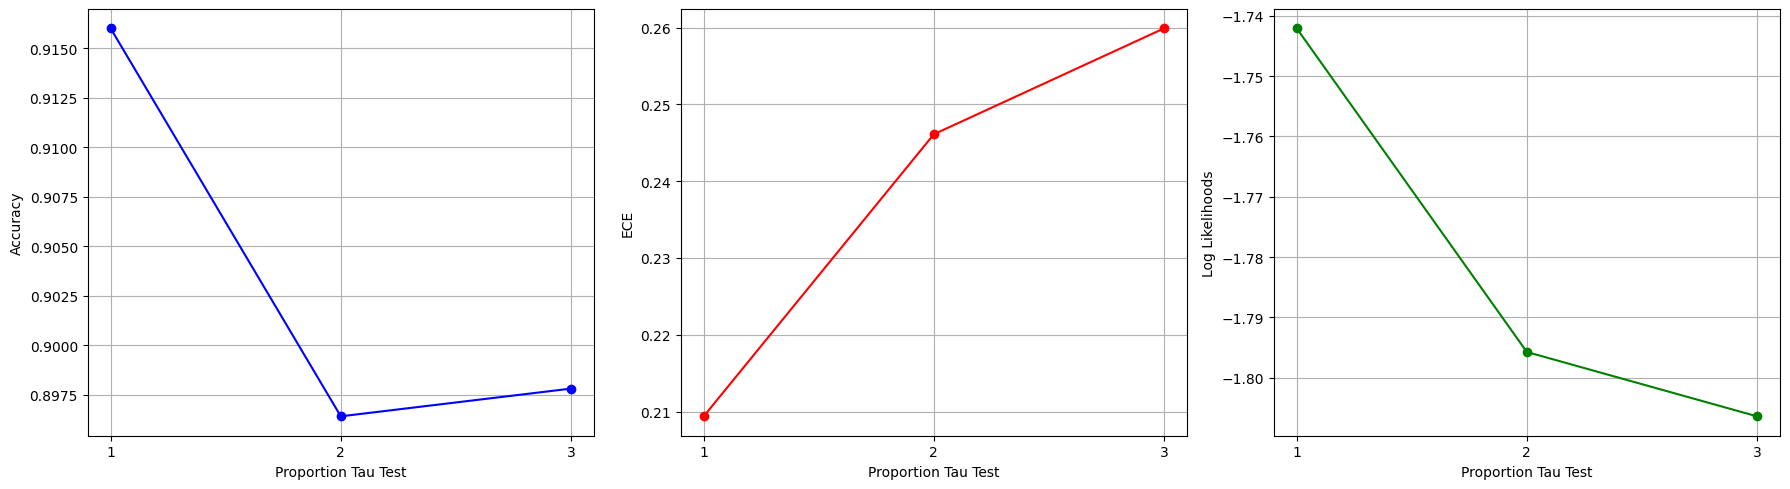

In [ ]:
list_chains = [1, 2, 3]
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Tracé des courbes sur chaque sous-graphique
ax[0].plot(list_chains, accuracies_chain, color='b', marker="o")
ax[0].set_xlabel('Proportion Tau Test')
ax[0].set_ylabel('Accuracy')
ax[0].grid(True)
ax[0].set_xticks(list_chains)

ax[1].plot(list_chains, ECEs_chain, color='r', marker="o")
ax[1].set_xlabel('Proportion Tau Test')
ax[1].set_ylabel('ECE')
ax[1].grid(True)
ax[1].set_xticks(list_chains)

ax[2].plot(list_chains, log_likelihoods_chain, color='g', marker="o")
ax[2].set_xlabel('Proportion Tau Test')
ax[2].set_ylabel('Log Likelihoods')
ax[2].grid(True)
ax[2].set_xticks(list_chains)

# Ajustement de la disposition
plt.tight_layout()
# Affichage du graphique
plt.show()